In [11]:
from google.colab import drive
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import load_img, img_to_array


In [12]:
# Mount Google Drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define dataset paths
original_dataset_dir = '/content/drive/MyDrive/hackdata'
base_dir = '/content/pepper_split_dataset'
# Define train, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Define class names
class_names = ['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy']


In [8]:
# Create directories for train, validation, and test
os.makedirs(base_dir, exist_ok=True)
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

# Split data
for class_name in class_names:
    class_path = os.path.join(original_dataset_dir, class_name)
    images = os.listdir(class_path)

    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    for img in train:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
    for img in test:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


In [9]:
# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1736 images belonging to 2 classes.
Found 373 images belonging to 2 classes.
Found 373 images belonging to 2 classes.


In [10]:
# Define a simple CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
cnn_model.summary()

# Extract features from the CNN
train_features = cnn_model.predict(train_generator)
val_features = cnn_model.predict(val_generator)
test_features = cnn_model.predict(test_generator)

# Get corresponding labels
train_labels = train_generator.classes
val_labels = val_generator.classes
test_labels = test_generator.classes


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,352 (40.57 MB)

 Trainable params: 10,636,352 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step


In [11]:
# Train an SVM classifier
svm = SVC(kernel='linear', probability=True)
svm.fit(train_features, train_labels)

# Evaluate SVM
svm_predictions = svm.predict(test_features)
print("SVM Classification Report:")
print(classification_report(test_labels, svm_predictions))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.71       150
           1       0.79      0.87      0.83       223

    accuracy                           0.79       373
   macro avg       0.78      0.77      0.77       373
weighted avg       0.78      0.79      0.78       373



In [12]:
# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)

# Evaluate Random Forest
rf_predictions = rf.predict(test_features)
print("Random Forest Classification Report:")
print(classification_report(test_labels, rf_predictions))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       150
           1       0.81      0.86      0.83       223

    accuracy                           0.80       373
   macro avg       0.79      0.78      0.78       373
weighted avg       0.79      0.80      0.79       373



In [36]:
print(".")

.


In [17]:
# Load a single image
img_path = '/content/drive/MyDrive/hackdata/Pepper,_bell___Bacterial_spot/image (1).JPG'
img = load_img(img_path, target_size=(150, 150))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Extract features using CNN
single_feature = cnn_model.predict(img_array)

# Predict using SVM
svm_prediction = svm.predict(single_feature)
svm_class = class_names[svm_prediction[0]]

# Predict using Random Forest
rf_prediction = rf.predict(single_feature)
rf_class = class_names[rf_prediction[0]]

print(f"SVM Prediction: {svm_class}")
print(f"Random Forest Prediction: {rf_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
SVM Prediction: Pepper,_bell___healthy
Random Forest Prediction: Pepper,_bell___Bacterial_spot


In [20]:
print(".")

.


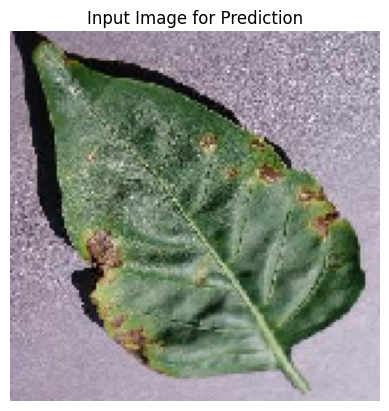

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
SVM Prediction: Pepper,_bell___healthy
Random Forest Prediction: Pepper,_bell___Bacterial_spot

🌱 **Farmer Recommendation**:
The bell pepper plant leaf is affected by bacterial spot.
- Remove infected leaves or plants to prevent spread.
- Avoid overhead watering; instead, water at the soil level.
- Use copper-based fungicides as per agricultural guidelines.
- Rotate crops to prevent recurring infections.


In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Load and display the image
img_path = '/content/drive/MyDrive/hackdata/Pepper,_bell___Bacterial_spot/image (1).JPG'
img = load_img(img_path, target_size=(150, 150))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image for Prediction")
plt.show()

# Preprocess the image for prediction
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Extract features using CNN
single_feature = cnn_model.predict(img_array)

# Predict using SVM
svm_prediction = svm.predict(single_feature)
svm_class = class_names[svm_prediction[0]]

# Predict using Random Forest
rf_prediction = rf.predict(single_feature)
rf_class = class_names[rf_prediction[0]]

# Display predictions
print(f"SVM Prediction: {svm_class}")
print(f"Random Forest Prediction: {rf_class}")

# Farmer recommendations
if svm_class == "Pepper,_bell___Bacterial_spot" or rf_class == "Pepper,_bell___Bacterial_spot":
    print("\n🌱 **Farmer Recommendation**:")
    print("The bell pepper plant leaf is affected by bacterial spot.")
    print("- Remove infected leaves or plants to prevent spread.")
    print("- Avoid overhead watering; instead, water at the soil level.")
    print("- Use copper-based fungicides as per agricultural guidelines.")
    print("- Rotate crops to prevent recurring infections.")
else:
    print("\n🌱 **Farmer Recommendation**:")
    print("The bell pepper plant leaf is healthy. Continue maintaining good agricultural practices.")


In [38]:
# Define the model architecture (Update the final Dense layer to have 2 output units for binary classification)
cnn_model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),  # Input size (150x150 RGB image)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Final layer with 2 output units (for two classes: healthy, bacterial spot)
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model if not already trained
cnn_model.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3779 - loss: 1.4216 - val_accuracy: 0.5979 - val_loss: 0.6807
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5657 - loss: 0.6878 - val_accuracy: 0.4021 - val_loss: 0.6913
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5720 - loss: 0.6930 - val_accuracy: 0.5979 - val_loss: 0.6622
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.5763 - loss: 0.7127 - val_accuracy: 0.7748 - val_loss: 0.5756
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7509 - loss: 0.5413 - val_accuracy: 0.8338 - val_loss: 0.3906
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8179 - loss: 0.4138 - val_accuracy: 0.9062 - val_loss: 0.2689
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8926 - loss: 0.3034 - val_accuracy: 0.9142 - val_loss: 0.2399
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9142 - loss: 0.2106 - val_accuracy: 0.8820 - val_loss

In [39]:
# Step 1: Evaluate CNN on Test Data
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_generator, verbose=1)
print(f"\n✅ CNN Test Loss: {cnn_loss:.4f}")
print(f"✅ CNN Test Accuracy: {cnn_accuracy:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 801ms/step - accuracy: 0.9661 - loss: 0.1068

✅ CNN Test Loss: 0.1183
✅ CNN Test Accuracy: 0.9571


In [23]:
print("s")


s


In [21]:
print("s")


s


In [20]:
print("s")

s


In [19]:
print("s")

s


# New section